# Load and Resize images

In [1]:
#importing required libraries
import cv2
import numpy as np 
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage import data_dir
from skimage import color
from skimage.transform import resize
from skimage.feature import hog
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.decomposition import PCA
from skimage.feature import corner_harris, corner_subpix, corner_peaks


images = io.ImageCollection('easy/jpg/*.jpg')
Resizeimages=[]
counter=0
for img in images:
    #resizing image
    resized_img = cv2.resize(img, (128, 128)) #Resize images
    Resizeimages.append(resized_img)
    counter+=1
    #if(counter==1000):
            #break

Resizeimages= np.array(Resizeimages)
print(Resizeimages.shape)    
labels = np.loadtxt("easy/flowers_labels.txt").astype(int)   
print(labels)


(112, 128, 128, 3)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3]


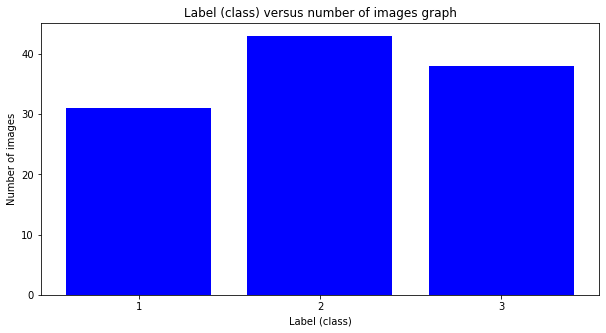

In [2]:
y,counts=np.unique(labels, return_counts=True)
fig = plt.figure(figsize = (10, 5))
plt.bar(y,counts,color ='blue', width = 0.8)
plt.xticks(np.arange(min(y), max(y)+1, 1.0))
plt.xlabel('Label (class)')
plt.ylabel('Number of images')
plt.title('Label (class) versus number of images graph')
plt.show()

# Show class images

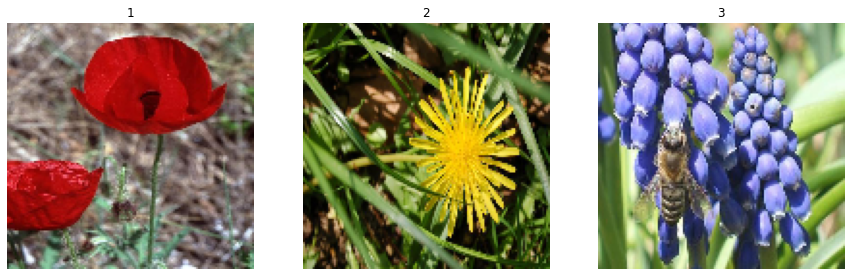

In [3]:
c=0
imgs=[]
titles=[]
for i in range(len(counts)):
    titles.append(str(labels[c]))
    imgs.append(Resizeimages[c])
    c+=counts[i]
    c+=1
    
plt.figure(figsize=(15,8))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(titles[i])
    plt.imshow(imgs[i]) 
    plt.axis('off')

# Split Dataset

In [4]:
X_train, X_test, y_train, y_test = train_test_split(Resizeimages, labels, test_size=0.5, random_state=42)
print(labels.shape)

(112,)


# Feature Extraction

In [5]:
def featureExtractor(Data):
    
    hog_features = []
    edge_features = []
    RGB=[]
    HSV=[]
    
    for img in Data:
        
        #HOG
        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)
        #hog_images.append(hog_image)
        hog_features.append(fd)
        
        #EDGE
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_blur = cv2.GaussianBlur(gray_img, (3,3), 0)
        edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
        edge_features.append(edges)
        
        #RGB Cluster
        reshapeimg = img.reshape((img.shape[0] * img.shape[1],3)) #represent as row*column,channel number
        clt = KMeans(n_clusters=10) #cluster number
        clt.fit(reshapeimg)
        RGB.append(clt.cluster_centers_)
        
        #HSV Cluster
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hsvimg = hsv.reshape((hsv.shape[0] * hsv.shape[1],3)) #represent as row*column,channel number
        clt2 = KMeans(n_clusters=10) #cluster number
        clt2.fit(hsvimg)
        HSV.append(clt2.cluster_centers_)
        
    hog_features=np.array(hog_features)
    edge_features=np.array(edge_features)
    RGB=np.array(RGB)
    HSV=np.array(HSV)
    return hog_features,edge_features,RGB,HSV

In [6]:
hogs_train,edges_train,rgbs_train,hsvs_train=featureExtractor(X_train)

print(hogs_train.shape)

(56, 8100)


In [7]:
edges_train=edges_train.reshape(len(X_train),-1)
print(edges_train.shape)

(56, 16384)


In [8]:
rgbs_train=rgbs_train.reshape(len(X_train),-1)
print(rgbs_train.shape)

(56, 30)


In [9]:
hsvs_train=hsvs_train.reshape(len(X_train),-1)
print(hsvs_train.shape)

(56, 30)


In [10]:
hogs_test,edges_test,rgbs_test,hsvs_test=featureExtractor(X_test)
hogs_test.shape

(56, 8100)

In [11]:
edges_test=edges_test.reshape(len(X_test),-1)
rgbs_test=rgbs_test.reshape(len(X_test),-1)
hsvs_test=hsvs_test.reshape(len(X_test),-1)
print(edges_test.shape)
print(rgbs_test.shape)
print(hsvs_test.shape)

(56, 16384)
(56, 30)
(56, 30)


# Find Accuracy for every feature and classifier

In [12]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
hogs_train = scaler.fit_transform(hogs_train)
hogs_test = scaler.fit_transform(hogs_test)

#Define the classifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

RF_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

#Random Forest for HOG
RF_model.fit(hogs_train, y_train) 
y_rf_hog = RF_model.predict(hogs_test)

#SVM for HOG
ovr = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=2)
)
ovr.fit(hogs_train, y_train)
y_svm_hog = ovr.predict(hogs_test) 

#KNN for HOG
knn = KNeighborsClassifier()
knn.fit(hogs_train, y_train)
y_knn_hog = knn.predict(hogs_test)

#Logistic for HOG
lr = OneVsRestClassifier(
    LogisticRegression(solver='lbfgs', max_iter=1000)
)
lr.fit(hogs_train, y_train)
y_lr_hog = lr.predict(hogs_test)

In [13]:
print("RF HOG Accuracy: "+str(accuracy_score(y_test, y_rf_hog)))
print('\n')
print("SVM Hog Accuracy: "+str(accuracy_score(y_test, y_svm_hog)))
print('\n')
print("KNN Hog Accuracy: "+str(accuracy_score(y_test, y_knn_hog)))
print('\n')
print("LR Hog Accuracy: "+str(accuracy_score(y_test, y_lr_hog)))
print('\n')

RF HOG Accuracy: 0.7321428571428571


SVM Hog Accuracy: 0.8035714285714286


KNN Hog Accuracy: 0.7857142857142857


LR Hog Accuracy: 0.8035714285714286




In [14]:
#SVM for edges
clf = svm.SVC()
clf.fit(edges_train, y_train)
y_svm_edge = clf.predict(edges_test) 

#KNN for edges
knn = KNeighborsClassifier()
knn.fit(edges_train, y_train)
y_knn_edge = knn.predict(edges_test)

#Logistic for edges
lr = LogisticRegression()
lr.fit(edges_train, y_train)
y_lr_edge = lr.predict(edges_test)

#Random Forest for edges
RF = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF.fit(edges_train, y_train) 
y_rf_edge = RF.predict(edges_test)

In [15]:
print("SVM Edge Accuracy: "+str(accuracy_score(y_test, y_svm_edge)))
print('\n')
print("KNN Edge Accuracy: "+str(accuracy_score(y_test, y_knn_edge)))
print('\n')
print("LR EDGE Accuracy: "+str(accuracy_score(y_test, y_lr_edge)))
print('\n')
print("RF EDGE Accuracy: "+str(accuracy_score(y_test,y_rf_edge )))
print('\n')

SVM Edge Accuracy: 0.39285714285714285


KNN Edge Accuracy: 0.30357142857142855


LR EDGE Accuracy: 0.7321428571428571


RF EDGE Accuracy: 0.5535714285714286




In [16]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rgbs_train = scaler.fit_transform(rgbs_train)
rgbs_test = scaler.fit_transform(rgbs_test)
hsvs_train = scaler.fit_transform(hsvs_train)
hsvs_test = scaler.fit_transform(hsvs_test)

#SVM for Color
clf = svm.SVC(kernel="linear", probability=True, random_state=0)
clf.fit(rgbs_train, y_train)
y_svm_Color = clf.predict(rgbs_test) 

#KNN for Color
knn = KNeighborsClassifier()
knn.fit(rgbs_train, y_train)
y_knn_Color = knn.predict(rgbs_test)

#Logistic for Color
lr = LogisticRegression()
lr.fit(rgbs_train, y_train)
y_lr_Color = lr.predict(rgbs_test)

#Random Forest for Color
RF = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF.fit(rgbs_train, y_train) 
y_rf_Color = RF.predict(rgbs_test)

In [17]:
print("SVM RGB Accuracy: "+str(accuracy_score(y_test, y_svm_Color)))
print('\n')
print("KNN RGB Accuracy: "+str(accuracy_score(y_test, y_knn_Color)))
print('\n')
print("LR RGB Accuracy: "+str(accuracy_score(y_test, y_lr_Color)))
print('\n')
print("RF RGB Accuracy: "+str(accuracy_score(y_test,y_rf_Color )))
print('\n')

SVM RGB Accuracy: 0.9285714285714286


KNN RGB Accuracy: 0.875


LR RGB Accuracy: 0.9285714285714286


RF RGB Accuracy: 0.6607142857142857




In [18]:
#SVM for HSV
clf = svm.SVC(kernel="linear", probability=True, random_state=0)
clf.fit(hsvs_train, y_train)
y_svm_hsv = clf.predict(hsvs_test) 

#KNN for HSV
knn = KNeighborsClassifier()
knn.fit(hsvs_train, y_train)
y_knn_hsv = knn.predict(hsvs_test)

#Logistic for HSV
lr = LogisticRegression()
lr.fit(hsvs_train, y_train)
y_lr_hsv = lr.predict(hsvs_test)

#Random Forest for HSV
RF = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF.fit(hsvs_train, y_train) 
y_rf_hsv = RF.predict(hsvs_test)

In [19]:
print("SVM HSV Accuracy: "+str(accuracy_score(y_test, y_svm_hsv)))
print('\n')
print("KNN HSV Accuracy: "+str(accuracy_score(y_test, y_knn_hsv)))
print('\n')
print("LR HSV Accuracy: "+str(accuracy_score(y_test, y_lr_hsv)))
print('\n')
print("RF HSV Accuracy: "+str(accuracy_score(y_test,y_rf_hsv )))
print('\n')

SVM HSV Accuracy: 0.6785714285714286


KNN HSV Accuracy: 0.7678571428571429


LR HSV Accuracy: 0.7142857142857143


RF HSV Accuracy: 0.7857142857142857




In [20]:
#Combining Features

train_features_=np.hstack((hogs_train,hsvs_train))

test_features_=np.hstack((hogs_test,hsvs_test))

#Logistic for HSV
lr = LogisticRegression()
lr.fit(train_features_, y_train)
predict = lr.predict(test_features_)

print("LR HOG + HSV Accuracy: "+str(accuracy_score(y_test, predict)))
print('\n')

LR HOG + HSV Accuracy: 0.8035714285714286




# Hyperparameter Tuning

In [21]:
train_features2_=np.hstack((hogs_train,rgbs_train,hsvs_train))
test_features2_=np.hstack((hogs_test,rgbs_test,hsvs_test))

from sklearn.model_selection import GridSearchCV
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = svm.SVC()
grid_svm = GridSearchCV(svc, param_grid)
grid_svm.fit(train_features2_, y_train)

y_pred_svm = grid_svm.predict(test_features2_)
print("Grid for Svm Accuracy: "+str(accuracy_score(y_test, y_pred_svm)))
print('\n')

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
param_grid = dict(solver=solvers,penalty=penalty,C=c_values)

lr = LogisticRegression()
grid_lr = GridSearchCV(lr, param_grid)
grid_lr.fit(train_features2_, y_train)

y_pred_svm = grid_lr.predict(test_features2_)
print("Grid lr Accuracy: "+str(accuracy_score(y_test, y_pred_svm)))
print('\n')

Grid for Svm Accuracy: 0.8035714285714286


Grid lr Accuracy: 0.8035714285714286




In [22]:

scores = list()
clf=svm.SVC(**grid_svm.best_params_, probability=True, random_state=2)
clf.fit(train_features2_, y_train)
y_svm_pred = clf.predict(test_features2_)
acc_svm=accuracy_score(y_test, y_svm_pred)
scores.append(acc_svm)

lr = LogisticRegression(**grid_lr.best_params_)
lr.fit(train_features2_, y_train)
y_lr_pred = lr.predict(test_features2_)
acc_lr=accuracy_score(y_test, y_lr_pred)
scores.append(acc_lr)

knn = KNeighborsClassifier()
knn.fit(train_features2_, y_train)
y_knn_pred = knn.predict(test_features2_)
acc_knn=accuracy_score(y_test, y_knn_pred)
scores.append(acc_knn)

RF.fit(train_features2_, y_train) 
y_rf_pred = RF.predict(test_features2_)
acc_rf=accuracy_score(y_test, y_rf_pred)
scores.append(acc_rf)

print("SVM HOG + RGB + HSV Accuracy: ",acc_svm)
print('\n')
print("LR HOG + RGB + HSV Accuracy: ",acc_lr)
print('\n')
print("KNN HOG + RGB + HSV Accuracy: ",acc_knn)
print('\n')
print("Random Forest HOG + RGB + HSV Accuracy: ",acc_rf)
print('\n')

SVM HOG + RGB + HSV Accuracy:  0.8214285714285714


LR HOG + RGB + HSV Accuracy:  0.8214285714285714


KNN HOG + RGB + HSV Accuracy:  0.8035714285714286


Random Forest HOG + RGB + HSV Accuracy:  0.6964285714285714




# Use Voting Classifier to improve the performance of our model

In [24]:
#increase of weight SVM
#scores[0]=2
from sklearn.ensemble import VotingClassifier

models = list()
models.append(['svm', clf])
models.append(['lr', lr])
models.append(['knn', knn])
models.append(['RF', RF])

ensemble = VotingClassifier(estimators=models, voting='soft', weights=scores)
ensemble.fit(train_features2_, y_train)

voting_pred= ensemble.predict(test_features2_)
acc_voting = accuracy_score(y_test, voting_pred)
print("VOTING HOG + RGB + HSV Accuracy: ",acc_voting)
print('\n')

VOTING HOG + RGB + HSV Accuracy:  0.8214285714285714




              precision    recall  f1-score   support

           1       0.85      0.65      0.73        17
           2       0.96      0.92      0.94        24
           3       0.65      0.87      0.74        15

    accuracy                           0.82        56
   macro avg       0.82      0.81      0.80        56
weighted avg       0.84      0.82      0.82        56



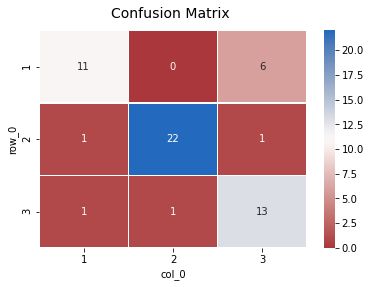

In [26]:
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report


cf_matrix = confusion_matrix(y_test, voting_pred)
cf_matrix = pd.crosstab(y_test,voting_pred)
sns.heatmap(cf_matrix,annot=True, cmap="vlag_r",linewidths=.5)
plt.title("Confusion Matrix ", fontsize=14, y=1.03);

print(classification_report(y_test,voting_pred))

# ROC Curve

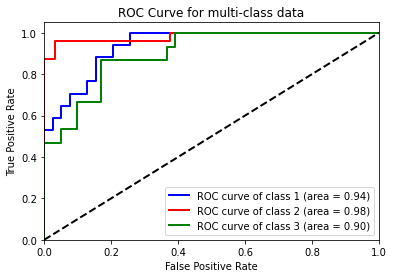

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_score = ensemble.fit(train_features2_, y_train).predict_proba(test_features2_)
n_classes = 3
# Binarize the output
y_test_roc = label_binarize(y_test, classes=[1, 2, 3])

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

d=[]

ensemble.fit(hogs_train, y_train)
y_pred = ensemble.predict(hogs_test)
x=confusion_matrix(y_test, y_pred)
d.append(np.diag(x))

print("Ensemble Accuracy for HOG: "+str(accuracy_score(y_test, y_pred)))
print('\n')

ensemble.fit(rgbs_train, y_train)
y_pred = ensemble.predict(rgbs_test)
x=confusion_matrix(y_test, y_pred)
d.append(np.diag(x))

print("Ensemble Accuracy for RGB: "+str(accuracy_score(y_test, y_pred)))
print('\n')


ensemble.fit(hsvs_train, y_train)
y_pred = ensemble.predict(hsvs_test)
x=confusion_matrix(y_test, y_pred)
d.append(np.diag(x))

print("Ensemble Accuracy for HSV: "+str(accuracy_score(y_test, y_pred)))
print('\n')


Ensemble Accuracy for HOG: 0.8035714285714286


Ensemble Accuracy for RGB: 0.8928571428571429


Ensemble Accuracy for HSV: 0.7142857142857143




# Features's contribution to true values

<AxesSubplot:>

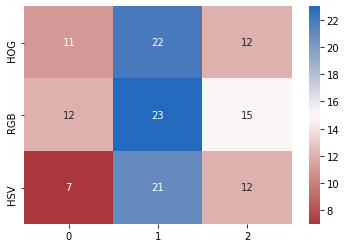

In [29]:
import seaborn as sns

x_axis_labels = y_test # labels for x-axis
y_axis_labels = ["HOG","RGB","HSV"] # labels for y-axis
sns.heatmap(d,annot=True,yticklabels=y_axis_labels, cmap="vlag_r")


# Reduce Dimension

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(edges_train)

X_pca=pca.transform(edges_train)
print(X_pca.shape)

pca = PCA(n_components=50)
pca.fit(edges_test)
X_pca2=pca.transform(edges_test)
print(X_pca2.shape)


(56, 50)
(56, 50)


In [31]:
train_features3=np.hstack((hogs_train,rgbs_train,hsvs_train,X_pca))
test_features3=np.hstack((hogs_test,rgbs_test,hsvs_test,X_pca2))

ensemble = VotingClassifier(estimators=models, voting='soft', weights=scores)
ensemble.fit(train_features3, y_train)

voting_pca= ensemble.predict(test_features3)
acc_pca = accuracy_score(y_test, voting_pca)
print("VOTING HOG + RGB + HSV + EDGE Accuracy: ",acc_pca)
print('\n')

VOTING HOG + RGB + HSV + EDGE Accuracy:  0.4107142857142857




# Show misclassification

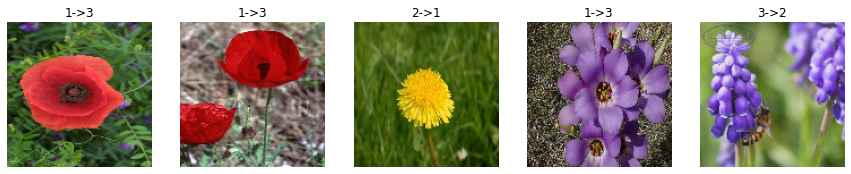

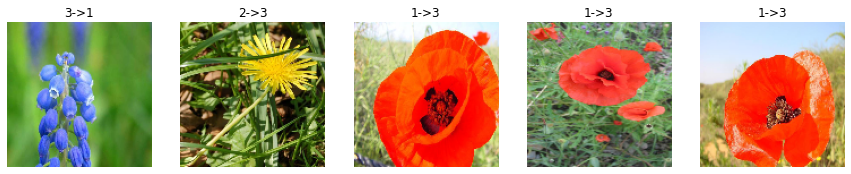

In [32]:
#detect misclassification
imgs=[]
titles=[]
c=0
for img in X_test:
    if y_test[c]!=voting_pred[c]:
        titles.append(str(y_test[c])+"->"+str(voting_pred[c]))
        imgs.append(img)
    c+=1

#show misclassification images 
row=0
while(row<len(titles)):
    
    plt.figure(figsize=(15,8))
    for i in range(5):    
        if(row+i>=len(titles)):
            break
        plt.subplot(1,5,i+1)
        plt.title(titles[row+i])
        plt.imshow(imgs[row+i]) 
        plt.axis('off') 
    row+=5
    